In [1]:
import itertools
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
with_cuda = torch.cuda.is_available()
if with_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

**Rendu du notebook : envoyer le notebook par mail à pierre.wolinski@dauphine.psl.eu**

**Barème indicatif**

12 questions sur 16 points :
1. 2 points
2. 1 point
3. 1 point
4. 2 points
5. 2 points
6. 1 point
7. 1 point
8. 1 point
9. 1 point
10. 2 points
11. 1 point
12. 1 point

# Utilisation et élagage d'un réseau de neurones

Le but de ce notebook est d'implémenter une technique simple d'élagage de réseau de neurones. L'élagage consiste à "supprimer" des paramètres du réseau en les mettant à zero. De cette façon, le réseau peut être compressé et être stocké et utilisé plus efficacement.

Avant cela, plusieurs étapes fondamentales de manipulation des réseaux de neurones sont proposées.

## Génération du dataset

On définit ici quelques fonctions permettant de générer un dataset.

Exécutez la cellule suivante.

In [ ]:
def generate_c1(s, r, r2, device):
    t = torch.zeros(s, s, device = device)
    x = r + torch.randint(s - 2*r, (1,))
    y = r + torch.randint(s - 2*r, (1,))
    for i, j in itertools.product(range(s), range(s)):
        if (i - x)**2 + (j - y)**2 <= r2:
            t[i, j] = 1

    return t

def generate_c2(s, r, r2, device):
    t = torch.zeros(s, s, device = device)
    x = r + torch.randint(s - 2*r, (1,))
    y = r + torch.randint(s - 2*r, (1,))
    t[x-r:x+r+1,y-r:y+r+1].fill_(1)

    return t

def generate_c3(s, r, r2, device):
    t = torch.zeros(s, s, device = device)
    x = r + torch.randint(s - 2*r, (1,))
    y = r + torch.randint(s - 2*r, (1,))
    for i, j in itertools.product(range(s), range(s)):
        if (i - x).abs() + (j - y).abs() <= r:
            t[i, j] = 1

    return t

def add_noise(s, p, t_in):
    for i in range(p):
        x = torch.randint(s, (1,))
        y = torch.randint(s, (1,))
        t_in[x, y] = 1 - t_in[x, y]

def generate_point(s, r, r2, p, device):
    cl = torch.randint(3, (1,)).item()
    if cl == 0:
        img = generate_c1(s, r, r2, device)
    elif cl == 1:
        img = generate_c2(s, r, r2, device)
    else:
        img = generate_c3(s, r, r2, device)

    add_noise(s, p, img)

    return img, cl

def build_dataset(n, device):
    s = 16
    r = 4
    r2 = r**2
    p = 3

    images = torch.zeros((n, 1, s, s), device = device)
    classes = torch.LongTensor(n).to(device)
    for i in range(n):
        images[i], classes[i] = generate_point(s, r, r2, p, device)

    return torch.utils.data.TensorDataset(images, classes)


À présent, on construit le training set et le test set. Exécutez la cellule suivante.

In [ ]:
train_data = build_dataset(1000, device)
test_data = build_dataset(200, device)

train_size = len(train_data)
test_size= len(test_data)

classes = [f"{i}" for i in range(3)]
print(train_size, test_size)

print(train_data[0][1])

images, labels = train_data.tensors


1000 200
tensor(2)
tensor([2, 1, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 1, 0, 0, 2, 2, 2,
        2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 2, 1,
        1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 2,
        1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 1, 0,
        2, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 0, 2,
        2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0,
        0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 0, 0,
        0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 0, 2,
        2, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 2, 1, 2, 2, 2, 0, 1, 0,
        2, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 1,
        2, 2, 1, 2, 1

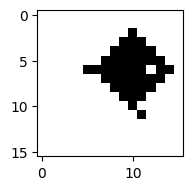

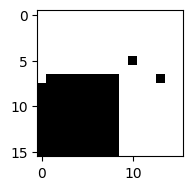

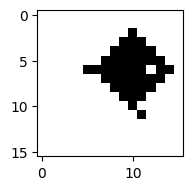

In [213]:
#plt.imshow(train_data[0][0].squeeze(), cmap = "Greys")
#plt.imshow(train_data[1][0].squeeze(), cmap = "Greys")
#plt.imshow(train_data[500][0].squeeze(), cmap = "Greys")
lab = set()
for i in labels:
    if i not in lab : 
        plt.subplot(1, 3, i.item()+1)
        plt.imshow(images[i].squeeze(), cmap = "Greys")
        plt.show()
    lab.add(i)
    if len(lab) == 3:
        break



**Question 1** (~ 2 pts)

Combien y a-t-il de classes dans ces datasets? Afficher une image de chaque classe.

Construire un `DataLoader` pour le training set et un autre pour le test set. On choisira `batch_size = 50`.

Qu'est-ce que le batch size ?

Il y a 3 classes dans chacun des datasets : classe 0, 1 ou 2

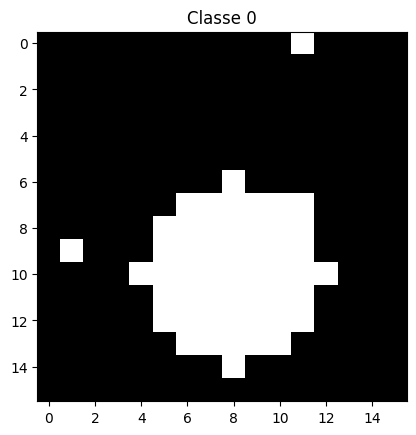

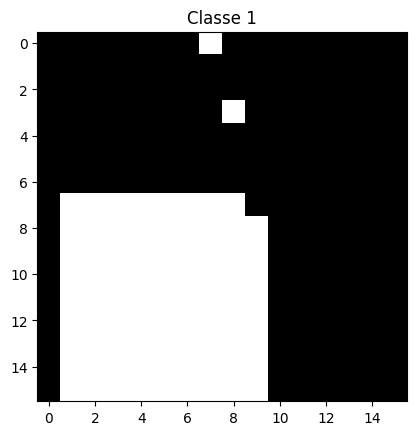

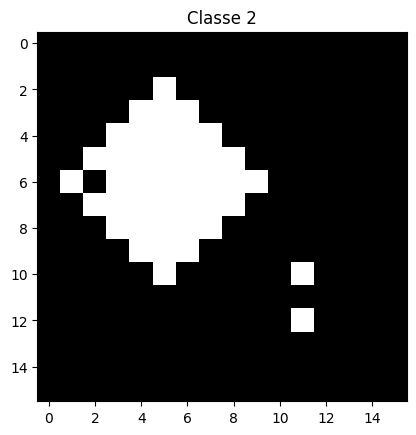

In [183]:
images, labels = train_data.tensors

shown = set()
for i in range(len(labels)):
    if labels[i].item() not in shown:
        plt.imshow(images[i][0].cpu(), cmap="gray")
        plt.title(f"Classe {labels[i].item()}")
        plt.show()
        shown.add(labels[i].item())
    if len(shown) == 3:
        break

In [135]:
batch_size = 50
dataloader_train= torch.utils.data.DataLoader(train_data, batch_size, shuffle =True)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size, shuffle = False)

## Construction de la descente de gradient

**Question 2** (~ 1 pt)

Donner l'équation de la descente de gradient. Définir les notations que vous utilisez.

$\theta(t+1)  = \theta(t) - \eta\nabla\theta(L(\theta(t)))$

$\eta$ : est le taux d'apprentissage, positif et réel\
$\theta$ : est le paramètre à apprendre \
$L$ : la fonction de Loss à minimiser




**Question 3** (~ 1 pt)

Compléter le code ci-dessous pour construire un optimiseur PyTorch qui implémente la descente de gradient. `lr` est le "learning rate", ou "taux d'apprentissage".

Notes :
* la liste des paramètres du modèle est stockée dans `self.param_groups[0]["params"]`;
* pour ajouter le tenseur `t2` au tenseur `t1`, on peut écrire `t1.add_(t2)`.

In [76]:
class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            for p in group["params"]:
                if p.grad is not None:
                    p.data.add_(-lr * p.grad.data)


## Fonction d'optimisation

On définit ainsi la fonction permettant d'optimiser un modèle :

In [38]:
def train_model(model, criterion, optimizer, nepochs):
    train_losses = []
    test_losses = []
    acc_eval = []

    for epoch in range(nepochs):
        train_loss = 0.
        model.train()
        for batch_idx, (data, target) in enumerate(dataloader_train):
            data = data.to(device = device)
            target = target.to(device = device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

        valid_loss, correct = test_model(model, criterion, optimizer, nepochs)

        train_loss = train_loss/len(dataloader_train.dataset)
        valid_loss = valid_loss/len(dataloader_test.dataset)
        acc_eval.append(correct/len(dataloader_test.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

def test_model(model, criterion, optimizer, nepochs):
    model.eval()
    correct = 0
    valid_loss = 0.
    for data, target in dataloader_test:
        with torch.no_grad():
            data = data.to(device = device)
            target = target.to(device = device)

            output = model(data)
            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    return valid_loss, correct

**Question 4** (~ 2 pts)

Construire une classe de modèles `SimpleModel` permettant de classifier les images des datasets `train_data` et `test_data`.

In [77]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        layers = [16*16, 64, 3]
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(layers[0], layers[1])
        self.fc2 = nn.Linear(layers[1], layers[2])
        self.reLU = nn.ReLU()
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x= self.reLU(x)
        x = self.fc2(x)

        return x
   

**Question 5** (~ 2 pts)

Construire une fonction `count_params` comptant le nombre de paramètres du modèle. Combien le modèle que vous avez défini ci-dessus a-t-il de paramètres ?

On pourra s'aider de :
* la méthode `parameters()`;
* la méthode `size()` ou toute autre méthode permettant de compter le nombre déléments dans un tenseur.

In [231]:
def count_params2(model):
    return sum(p.numel() for p in model.parameters())

model = SimpleModel()
print(count_params2((model)))

16643


**Question 6** (~ 1 pt)

Procéder à l'entraînement. Régler le modèle et le taux d'apprentissage de façon à avoir une loss finale inférieure à 0.001.

In [96]:
model = SimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = .1)

nepochs = 50


train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.077350 	Validation Loss: 1.050974
Epoch: 1 	Training Loss: 0.999474 	Validation Loss: 0.980130
Epoch: 2 	Training Loss: 0.907612 	Validation Loss: 0.889450
Epoch: 3 	Training Loss: 0.817056 	Validation Loss: 0.794176
Epoch: 4 	Training Loss: 0.721877 	Validation Loss: 0.701676
Epoch: 5 	Training Loss: 0.641396 	Validation Loss: 0.629082
Epoch: 6 	Training Loss: 0.577783 	Validation Loss: 0.575833
Epoch: 7 	Training Loss: 0.522966 	Validation Loss: 0.525743
Epoch: 8 	Training Loss: 0.484909 	Validation Loss: 0.486613
Epoch: 9 	Training Loss: 0.446081 	Validation Loss: 0.461651
Epoch: 10 	Training Loss: 0.421919 	Validation Loss: 0.439577
Epoch: 11 	Training Loss: 0.391917 	Validation Loss: 0.427060
Epoch: 12 	Training Loss: 0.366064 	Validation Loss: 0.386717
Epoch: 13 	Training Loss: 0.345472 	Validation Loss: 0.366017
Epoch: 14 	Training Loss: 0.319944 	Validation Loss: 0.361389
Epoch: 15 	Training Loss: 0.297724 	Validation Loss: 0.331265
Epoch: 16 	Trainin

## Élagage de réseau

**Question 7** (~ 1 pt)

Construire la fonction `penalty_l1`, qui prend en argument un modèle et renvoie la somme des valeurs absolues de tous ses paramètres.

In [224]:
def penalty_l1(model):
    return sum(torch.sum(torch.abs(parameter)) for parameter in model.parameters())

**Question 8** (~ 1 pt)

Construire la fonction `train_model_penalty`, qui est inspirée de la fonction `train_model`, mais qui permet d'entraîner le modèle avec une loss pénalisée.

Par exemple, au lieu de minimiser :
$$
\mathcal{L}(\theta) = \ell(\theta) ,
$$
on minimisera :
$$
\mathcal{L}(\theta) = \ell(\theta) + \lambda \cdot \verb|penalty_l1|(\theta) ,
$$
où $\theta$ représente le modèle.

In [225]:
def train_model_penalty(model, criterion, optimizer, nepochs, lmb):
    train_losses = []
    test_losses = []
    acc_eval = []

    for epoch in range(nepochs):
        train_loss = 0.
        model.train()
        for batch_idx, (data, target) in enumerate(dataloader_train):
            data = data.to(device = device)
            target = target.to(device = device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) 
            loss_tot = loss + lmb*penalty_l1(model)
            loss_tot.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

        valid_loss, correct = test_model(model, criterion, optimizer, nepochs)

        train_loss = train_loss/len(dataloader_train.dataset)
        valid_loss = valid_loss/len(dataloader_test.dataset)
        acc_eval.append(correct/len(dataloader_test.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

def test_model(model, criterion, optimizer, nepochs):
    model.eval()
    correct = 0
    valid_loss = 0.
    for data, target in dataloader_test:
        with torch.no_grad():
            data = data.to(device = device)
            target = target.to(device = device)

            output = model(data)
            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    return valid_loss, correct

**Question 9** (~ 1 pt)

Entraîner le modèle avec la pénalité $\ell^1$ (`penalty_l1`) et un facteur $\lambda = 0.0003$. On cherchera à avoir une loss totale inférieure à 0.1.

Sauvegarder le modèle final.

In [226]:
model = SimpleModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr =.1)
criterion = nn.CrossEntropyLoss()
lmb = .0003
nepochs = 50

train_model_penalty(model, criterion, optimizer, nepochs, lmb)

torch.save(model.state_dict(), "model_l1.pth")

Epoch: 0 	Training Loss: 1.062882 	Validation Loss: 1.035908
Epoch: 1 	Training Loss: 0.988020 	Validation Loss: 0.965048
Epoch: 2 	Training Loss: 0.892440 	Validation Loss: 0.880308
Epoch: 3 	Training Loss: 0.802679 	Validation Loss: 0.792276
Epoch: 4 	Training Loss: 0.715445 	Validation Loss: 0.701586
Epoch: 5 	Training Loss: 0.637197 	Validation Loss: 0.628486
Epoch: 6 	Training Loss: 0.574544 	Validation Loss: 0.581776
Epoch: 7 	Training Loss: 0.523480 	Validation Loss: 0.523288
Epoch: 8 	Training Loss: 0.482624 	Validation Loss: 0.491991
Epoch: 9 	Training Loss: 0.451793 	Validation Loss: 0.472385
Epoch: 10 	Training Loss: 0.415421 	Validation Loss: 0.437238
Epoch: 11 	Training Loss: 0.394381 	Validation Loss: 0.426985
Epoch: 12 	Training Loss: 0.367872 	Validation Loss: 0.386552
Epoch: 13 	Training Loss: 0.348634 	Validation Loss: 0.378566
Epoch: 14 	Training Loss: 0.323856 	Validation Loss: 0.350345
Epoch: 15 	Training Loss: 0.300519 	Validation Loss: 0.387887
Epoch: 16 	Trainin

**Question 10** (~ 2 pts)

Construire une fonction `prune_model` qui prend en argument le modèle à élaguer et un paramètre `threshold`. Cette fonction doit remplacer par 0 tous les paramètres du modèle dont la valeur absolue est plus petite que `threshold`. Cette fonction doit renvoyer le nombre de paramètres qui n'ont pas été mis à 0.

Notes :
* lorsque `t` est un tenseur et `a` un nombre réel, `t >= a` renvoie un tenseur booléen de même taille que `t` qui contient `True` à l'emplacement des éléments de `t` qui sont plus grands que `a`, et `False` pour les autres;
* un tenseur booléen `t` peut être converti en tenseur de nombres flottants (`float`) via : `t.float()`. Les `True` sont alors transformés en 1, et les `False` en 0.

In [227]:
def prune_model(model, threshold):
    count = 0
    for p in model.parameters():
        crit = (torch.abs(p) >= threshold).float()
        p.data.mul_(crit)
        count +=crit.sum().item()
    return count

**Question 11** (~ 1 pt)

Appliquer la fonction `prune_model` au modèle entraîné de façon à mettre à 0 entre 75% et 80% des paramètres. Pour cela, on réglera `threshold` à une valeur adéquate.

Note : on pensera à re-charger le modèle sauvegardé en mémoire à chaque tentative.

In [126]:
model.load_state_dict(torch.load("model_l1.pth"))

initial_params = count_params2(model)

remaining = prune_model(model, threshold=0.02)

print("Pourcentage restant :", 100*remaining/initial_params)

Pourcentage restant : 38.71297242083759


**Question 12** (~ 1 pt)

Évaluer la qualité du modèle élagué en calculant sa loss (non pénalisée) ainsi que son accuracy. Comparer avec le même modèle avant élagage.

In [127]:
valid_loss, correct = test_model(model, criterion, optimizer, 1)

valid_loss /= len(dataloader_test.dataset)
accuracy = 100 * correct / len(dataloader_test.dataset)

print("Loss:", valid_loss)
print("Accuracy:", accuracy)

Loss: 0.111544294282794
Accuracy: 98.0
